In [139]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

RANDOM_SEED = 42

In [140]:
# Para la compatibilidad de GPU y tensorflow uso
# tensorflow==2.10.1
# cuda = 11.2
# cudnn = 8.1.1
# python = 3.10.9
# https://www.tensorflow.org/install/source_windows?#gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print("GPUs Available: ", gpus)
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
      print(e)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Especificación de cada ruta

In [141]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
labels = 'model/keypoint_classifier/keypoint_classifier_label.csv'

# Configuración del número de clasificaciones

In [142]:
# Leer el contenido del archivo, eliminando el BOM si está presente
with open(labels, 'r', encoding='utf-8-sig') as f:
    content = f.read().splitlines()

# Convertir el contenido a un array de NumPy
labels_name = np.array(content, dtype=str)

print(labels_name)
NUM_CLASSES = len(labels_name)

['Open' 'Close' 'Pointer' 'mouse_up' 'mouse_down' 'mouse_left'
 'mouse_right' 'Ok' 'palma' 'mouse_diagonal_right_up'
 'mouse_diagonal_right_down' 'mouse_diagonal_left_up']


# Carga de datos de entrenamiento

In [143]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [144]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.60, random_state=RANDOM_SEED)

In [146]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=RANDOM_SEED)

# Construcción del modelo

In [147]:
from keras.regularizers import l2
model = keras.models.Sequential([
    keras.layers.Input((21 * 2, )),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [148]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                2752      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 12)               

In [149]:
# Callback de punto de control del modelo
cp_callback = keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para detención temprana
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [150]:
# Compilación del modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo

In [151]:
# Entrenar el modelo y guardar la historia
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/20
544/546 [============================>.] - ETA: 0s - loss: 1.7757 - accuracy: 0.4190
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
546/546 [==============================] - 4s 6ms/step - loss: 1.7749 - accuracy: 0.4190 - val_loss: 1.0642 - val_accuracy: 0.7393
Epoch 2/20
536/546 [============================>.] - ETA: 0s - loss: 1.2770 - accuracy: 0.5938
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
546/546 [==============================] - 3s 6ms/step - loss: 1.2763 - accuracy: 0.5937 - val_loss: 0.8332 - val_accuracy: 0.7736
Epoch 3/20
546/546 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.6518
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
546/546 [==============================] - 3s 5ms/step - loss: 1.1237 - accuracy: 0.6518 - val_loss: 0.7230 - val_accuracy: 0.7850
Epoch 4/20
544/546 [============================>.] - ETA: 0s - loss: 1.0348 - accuracy:

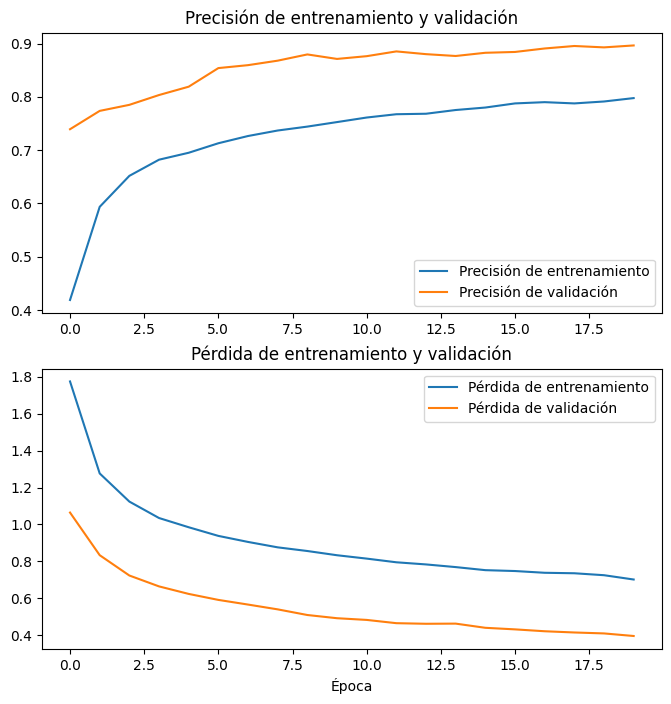

In [153]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

# Graficar la pérdida
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.show()

In [154]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_val, y_val, batch_size=128)

46/46 [==============================] - 0s 6ms/step - loss: 0.3933 - accuracy: 0.8998


In [155]:
# Carga del modelo guardado
model = tf.keras.models.load_model(model_save_path)

In [156]:
# Prueba de inferencia
predict_result = model.predict(np.array([X_val[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 51ms/step
[2.2251883e-03 9.9415612e-01 1.3335854e-03 2.1072261e-03 8.9770629e-06
 8.5353071e-07 4.2442323e-07 1.6605531e-04 1.9733994e-09 1.2964754e-06
 1.5819037e-13 2.8273976e-07]
1


# Matriz de confusión

182/182 [==============================] - 0s 2ms/step


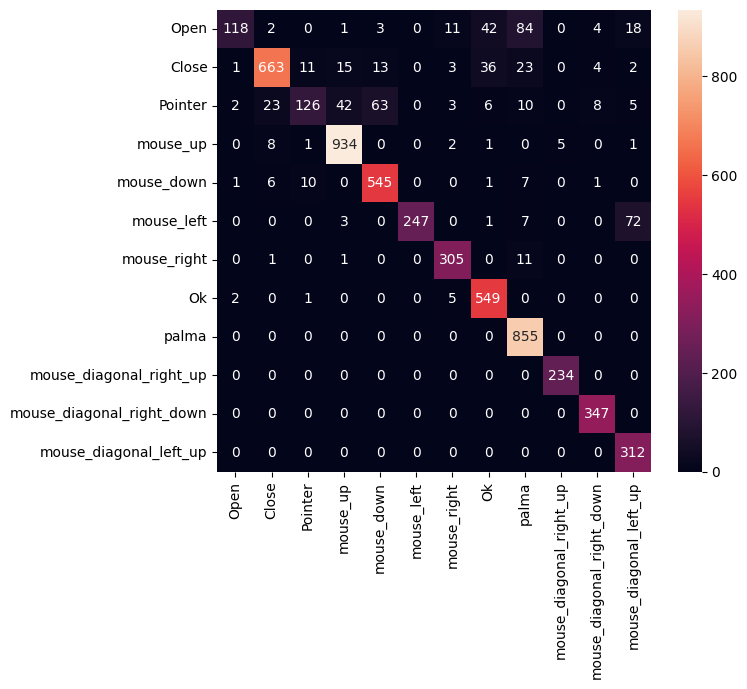

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.42      0.58       283
           1       0.94      0.86      0.90       771
           2       0.85      0.44      0.58       288
           3       0.94      0.98      0.96       952
           4       0.87      0.95      0.91       571
           5       1.00      0.75      0.86       330
           6       0.93      0.96      0.94       318
           7       0.86      0.99      0.92       557
           8       0.86      1.00      0.92       855
           9       0.98      1.00      0.99       234
          10       0.95      1.00      0.98       347
          11       0.76      1.00      0.86       312

    accuracy                           0.90      5818
   macro avg       0.91      0.86      0.87      5818
weighted avg       0.91      0.90      0.89      5818



In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, labels_name, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=range(len(labels_name)))
    
    df_cmx = pd.DataFrame(cmx_data, index=labels_name, columns=labels_name)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_val, y_pred))

Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_val, y_pred, labels_name)

# Conversión a modelo para Tensorflow-Lite

In [158]:
# Guardar como modelo exclusivamente para inferencia
model.save(model_save_path, include_optimizer=False)

In [159]:
# Modelo de conversión (cuantificación)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\GAMA\AppData\Local\Temp\tmpag14x_x2\assets


INFO:tensorflow:Assets written to: C:\Users\GAMA\AppData\Local\Temp\tmpag14x_x2\assets


10752

# Prueba de inferencia

In [161]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [162]:
# Obtener tensores de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [163]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_val[0]]))

In [164]:
%%time
# Realizar inferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 31.2 ms
Wall time: 997 µs


In [165]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.1434650e-03 9.9428988e-01 1.3150336e-03 2.0880338e-03 8.7754242e-06
 7.9534823e-07 4.0475851e-07 1.5202255e-04 1.7864753e-09 1.2608559e-06
 1.4876707e-13 2.5676934e-07]
1
